**Прогнозирование заказов такси. Временные ряды**
_____
**Описание исследования.**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.
    
_____
**Цель исследования.**

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Необходимо построить модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Задачи исследования.**

- Загрузить данные и выполнить их ресемплирование по одному часу.

- Проанализировать данные.

- Обучить разные модели с различными гиперпараметрами.

- Сделать тестовую выборку размером 10% от исходных данных.

- Проверить данные на тестовой выборке и сделайть выводы.

_____
**Исходные данные.**

Датасет `taxi.csv` содержит исторические данные о заказах такси

_____
**Содержание проекта.**

***Шаг 1. Загрузка данных:***
* [Загрузка библиотек.](#1-bullet)
* [Изученеие файла с данными, получение общей информации](#2-bullet)

***Шаг 2. Исследовательский анализ***
* [Распределение](#3-bullet)
* [Графики временных рядов и зависимостей](#4-bullet)

***Шаг 3. Подготовка выборок для обучения моделей***
* [Создание новых признаков](#5-bullet)

***Шаг 4. Обучение моделей***
* [Предсказание на тестовой выборке и график](#6-bullet)
* [График "факт - прогноз"](#7-bullet)

***Общий вывод***


## Шаг 1. Загрузка данных:

### Загрузка библиотек
<a id='1-bullet'></a>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from warnings import simplefilter
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import RandomizedSearchCV, train_test_split

simplefilter(action='ignore', category=FutureWarning)

### Изученеие файла с данными, получение общей информации
<a id='2-bullet'></a>

In [3]:
paths = [
    '/content',
    '/datasets',
    '/Users/admin/data'
]

for path in paths:
    file_path = f'{path}/taxi.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=[0], parse_dates=[0])
        break

display(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [4]:
#Проверка на хронологический порядок
print('Даты последовательны:', df.index.is_monotonic_increasing)

#Пропуски
print('Пропуски', df.isna().sum())

#Ресемплирование по часу
df = df.resample('1H').sum()

Даты последовательны: True
Пропуски num_orders    0
dtype: int64


## Шаг 2. Исследовательский анализ

### Распределение
<a id='3-bullet'></a>

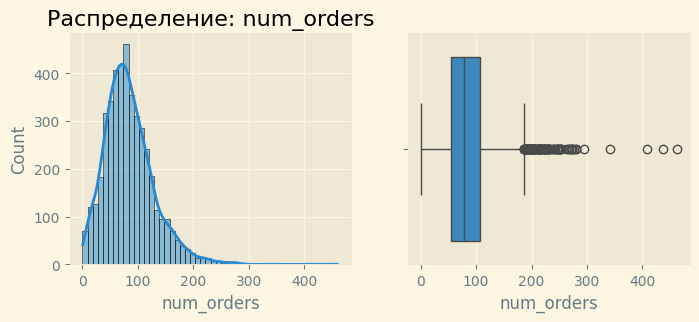

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [5]:
plt.style.use('Solarize_Light2')

plt.figure(figsize=(8,  3))

#Гистограмма
plt.subplot(1,  2,  1)
sns.histplot(df['num_orders'], kde=True, bins=50)
plt.title(f'Распределение: num_orders')

#Построение ящика
plt.subplot(1,  2,  2)
sns.boxplot(df['num_orders'], orient="h")
plt.setp(plt.gca(),  'yticklabels', [])

plt.show()
display(df.describe())

**Комментарий к гистограмме**

Большая часть данных находится в промежутке от 40 до 120. Есть выбросы, но их удалять по условию задания не буду

### Графики временных рядов и зависимостей
<a id='4-bullet'></a>

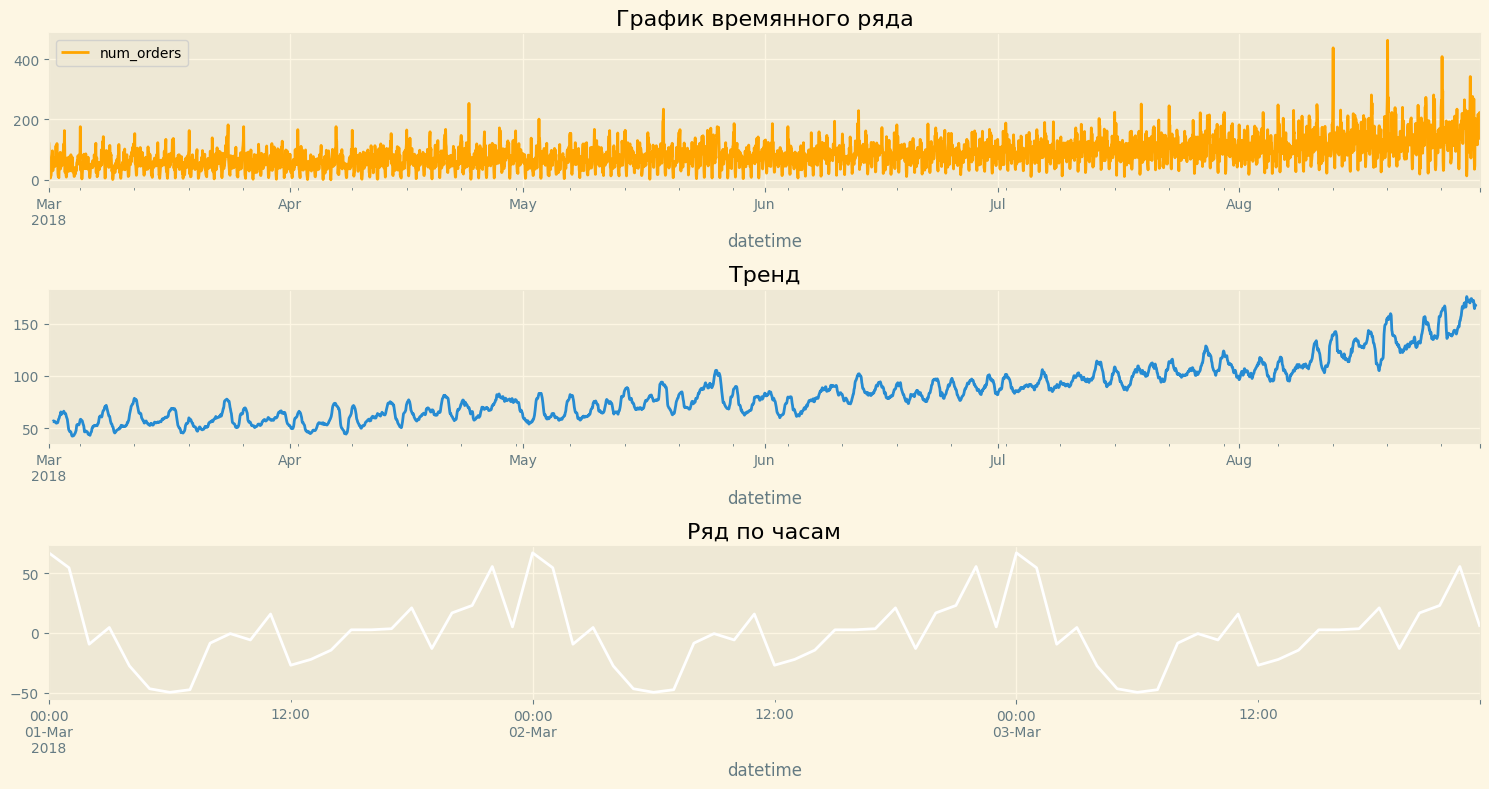

In [6]:
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(311)
df.plot(ax=ax1, color='orange')
ax1.set_title('График времянного ряда')

ax2 = fig.add_subplot(312)
seasonal_decompose(df).trend.plot(ax=ax2)
ax2.set_title('Тренд')

ax3 = fig.add_subplot(313)
seasonal_decompose(df['2018-03-01':'2018-03-3']).seasonal.plot(ax=ax3, color='white')
ax3.set_title('Ряд по часам')

plt.tight_layout()
plt.show()


**Комментарий к графикам**

- По графику временного ряда прослеживается возрастание количества заказов к концу года, что так-же подтверждается графиком тренда

- Большая часть заказов приходится на вечернее или ночное время

##Шаг 3. Подготовка выборок для обучения моделей

### Создание новых признаков
<a id='5-bullet'></a>

In [7]:
#Функция для создания календарных фичей
def time_feature(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

df_up = time_feature(df, 25, 50)

In [8]:
df_up = df_up.dropna()
train, test = train_test_split(df_up, shuffle=False, test_size=0.1)

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

##Шаг 4. Обучение моделей

In [9]:
cv_time_series = TimeSeriesSplit()

model = LinearRegression()
#model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=cv_time_series, scoring="neg_root_mean_squared_error")
final_score = scores.mean()
print('RMSE линейной регрессии на обучающей выборке:', -final_score.round(2))

param_grid_lightgbm = {
    'n_estimators': range(15, 46, 15),
    'max_depth': range(7, 21, 7),
    'num_leaves': range(15, 46, 15),
    'learning_rate': [0.1, 0.2, 0.3]
}

lgb_model = LGBMRegressor(verbose=-1)
grid_LGBM = GridSearchCV(lgb_model, param_grid_lightgbm, cv=cv_time_series, scoring="neg_root_mean_squared_error")
grid_LGBM.fit(X_train, y_train)

print('Лучшие параметры LGBM:', grid_LGBM.best_params_)
print('RMSE LGBM на обучающей выборке:', -grid_LGBM.cv_results_["mean_test_score"][0].round(2))

RMSE линейной регрессии на обучающей выборке: 27.17
Лучшие параметры LGBM: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 30, 'num_leaves': 15}
RMSE LGBM на обучающей выборке: 28.25


**Вывод**

Лучший результат на обучающей выборке показала модель LGBM

### Предсказание на тестовой выборке и график
<a id='6-bullet'></a>

In [10]:
predictions = grid_LGBM.best_estimator_.predict(X_test)
print('RMSE LGBM на тестовой выборке:', math.sqrt(mean_squared_error(y_test, predictions)))

RMSE LGBM на тестовой выборке: 40.33339390088675


### График "факт - прогноз"
<a id='7-bullet'></a>

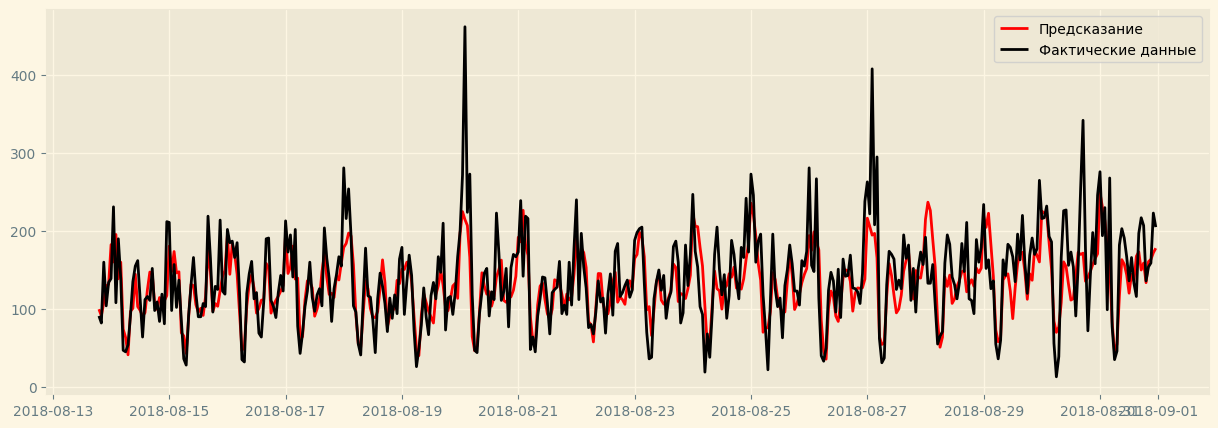

In [11]:
predictions = pd.DataFrame(predictions, index=X_test.index)
plt.figure(figsize=(15, 5))
plt.plot(predictions, color='red')
plt.plot(y_test, color='black')
plt.legend(['Предсказание', 'Фактические данные'])
plt.show()

## Общий вывод

В проекте рассмотрел тренды и сезонность в количестве заказов такси, на основе исторических данных о заказах

Обучил модель линейной регрессии и LGBM, подобрал опитмальные гиперпараметры и спрогнозировал количество заказов такси на тестовых данных
